### Import the necessary libraries


In [4]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

### Load the Dataset


In [3]:
df = pd.read_csv('Dataset/Training_Essay_Data.csv')
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


### Analyzing the missing values


<Axes: >

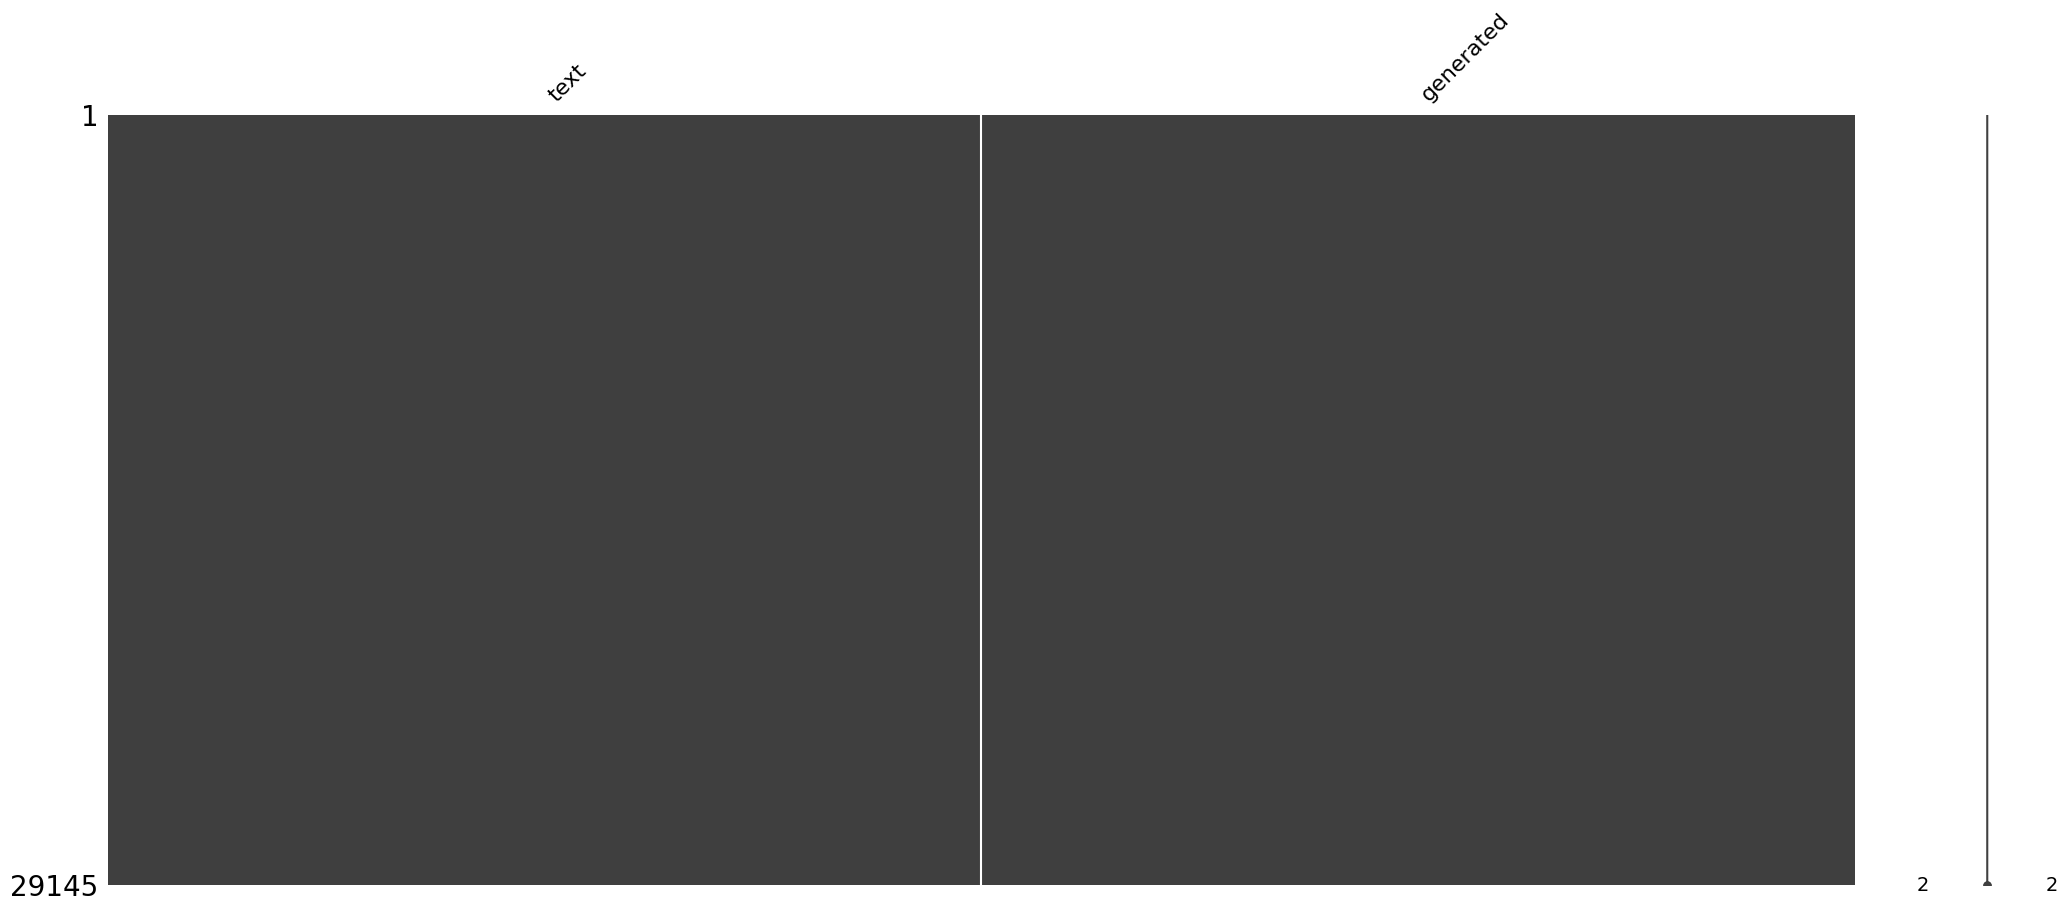

In [5]:
msno.matrix(df)

### Dataset Characterstics


Dataset size


In [8]:
df.shape

(29145, 2)

Checking for Duplicates


In [11]:
print('Duplicate Rows: ', len(df[df.duplicated()]))

Duplicate Rows:  1805


In [12]:
df.drop_duplicates(inplace=True)
df.shape

(27340, 2)

Check for data types


In [13]:
df.dtypes

text         object
generated     int64
dtype: object

Summary of Dataframe


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27340 entries, 0 to 27766
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27340 non-null  object
 1   generated  27340 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 640.8+ KB


Class Distribution


In [25]:
class_counts = df['generated'].value_counts()
class_counts

generated
0    16122
1    11218
Name: count, dtype: int64

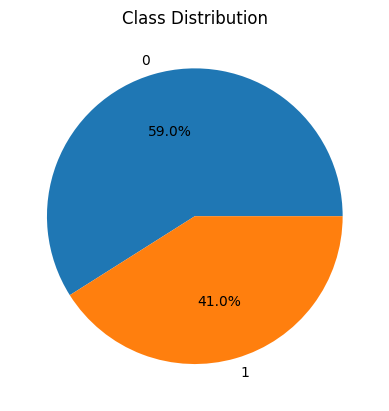

In [26]:
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

#### Initial Analysis of dataset

<ul>
    <li>Dataset initially had 29145 rows.</li>
    <li>There are only two columns in the dataset: text column has the essay text and generated column has the label (0 - Human Written Essay , 1 - AI Generated Essay).</li>
    <li>The dataset had no missing values.</li>
    <li>1805 rows with duplicate values were dropped.</li>
    <li>Almost 60% of the rows are human generated and 40% rows are AI generated.</li>
</ul>
